# Applying Machine Learning To Court Decision Prediction

### Load Opinion and Decision Data

In [2]:
import pandas as pd

court = pd.read_csv('predict_data.csv')
df= court[['text','affirm']]
df.columns = ['opinion', 'affirm']

In [3]:
df.head()

,opinion,author
0,Apple appeals from the final decision of the I...,moore
1,Followingbench trial on damages the district c...,prost
2,No claim to originalS Government Works Radio ...,moore
3,GE Lighting Solutions LLC GE appeals from the ...,moore
4,Tile Tech Inc Tile Tech appeals the decision o...,wallach


In [4]:
df.shape

(724, 2)

In [5]:
df['affirm'].value_counts()

prost        68
lourie       68
moore        65
taranto      63
dyk          63
o'malley     62
reyna        58
wallach      48
chen         34
bryson       33
newman       33
stoll        25
linn         25
rader        23
hughes       17
plager       12
schall       12
clevenger     6
mayer         5
o’malley      2
gajarsa       2
Name: author, dtype: int64

## Transforming documents into feature vectors

By calling the fit_transform method on CountVectorizer, we construct the vocabulary of the bag-of-words model and transformed the following opinion text into sparse feature vectors

### Bag-of-word Count for opinions and court decision

In [6]:
text_train = df['opinion']
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
vect = CountVectorizer().fit(text_train)
X = vect.transform(text_train)
print("X:\n{}".format(repr(X)))

X:
<724x165678 sparse matrix of type '<class 'numpy.int64'>'
	with 787132 stored elements in Compressed Sparse Row format>


In [8]:
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [9]:
feature_names = vect.get_feature_names()
print("Number of Unique Words: {}".format(len(feature_names)))

Number of Unique Words: 165678


### A naïve model based on word count

In [10]:
# Define predictor, and dependent variable
X = X # word count matrix
y= df['author']

print(X.shape)
print(y.shape)

(724, 165678)
(724,)


In [11]:
# Set up training and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape)
print(X_test.shape)

(543, 165678)
(181, 165678)


In [12]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

/anaconda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


KeyboardInterrupt: 

In [13]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.67
Best parameters:  {'C': 10}


In [14]:
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Test score: 0.63


### Narrow bag of words to words in at list 10 documents

In [15]:
vect = CountVectorizer(min_df=10).fit(text_train)
X = vect.transform(text_train)
print("X with min_df: {}".format(repr(X)))

X with min_df: <724x8554 sparse matrix of type '<class 'numpy.int64'>'
	with 555259 stored elements in Compressed Sparse Row format>


In [16]:
# Need index of new X data to subset y data accurately for new models
X.shape

(724, 8554)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape)
print(y_train.shape)


grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

(543, 8554)
(543,)
Best cross-validation score: 0.66


### Limit vocabulary to meaningful words by deleting Stop-words

In [18]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopword:
['eight', 'ourselves', 'among', 'whereas', 'has', 'former', 'bottom', 'empty', 'over', 'up', 'whatever', 'already', 'amoungst', 'sometime', 'as', 'six', 'enough', 'mill', 'an', 'by', 'show', 'on', 'more', 'often', 'whose', 'two', 'eg', 'whether', 'without', 'may', 'off', 'why']


In [19]:
# Specifying stop_words="english" uses the built-in list.
# We could also augment it and pass our own by building our own list.

vect = CountVectorizer(min_df=10, stop_words="english").fit(text_train)
X = vect.transform(text_train)
print("X with stop words:\n{}".format(repr(X_train)))

X with stop words:
<543x8554 sparse matrix of type '<class 'numpy.int64'>'
	with 409433 stored elements in Compressed Sparse Row format>


In [20]:
X.shape

(724, 8278)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.67


### Rescaling the Data with tf-idf

Term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in text mining. 

The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. 

Tf-idf is one of the most popular term-weighting schemes today; 83% of text-based recommender systems in digital libraries use tf-idf. 

The inverse document frequency factor is incorporated which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely. (From Wikipedia/Python for Machine Learning)

\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \log\big(\frac{N + 1}{N_w + 1}\big) + 1
\end{equation*}

In [22]:
# If we reweight our data in this way we increase the weight of repeated rare words in comments.  

from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(min_df=10, norm=None, stop_words="english").fit(text_train)
X = vect.transform(text_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)


Best cross-validation score: 0.64
Best parameters:  {'C': 0.1}


In [24]:
X.shape

(724, 8278)

In [23]:
grid.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Investigating model coefficients

In [36]:
# helper function to plot top positive and negative coefficients

def visualize_coefficients(coefficients, feature_names, n_top_features=25, 
                           fig_width = 12, fig_height = 6):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(fig_width,fig_height))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")
    plt.savefig('coef.png', dpi=400)
    



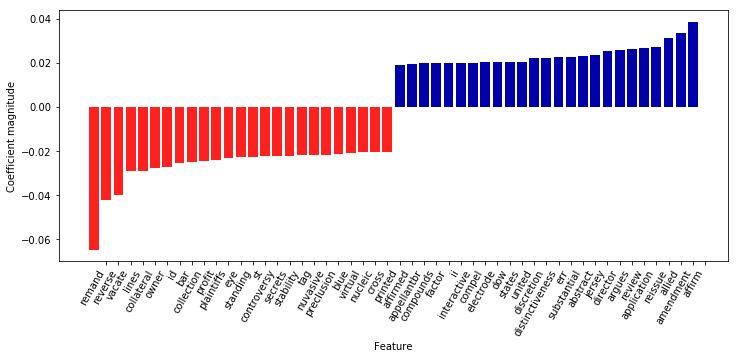

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

coefs = LogisticRegression(C=0.1).fit(X_train,y_train).coef_
feature_names = vect.get_feature_names()


visualize_coefficients(coefs, feature_names, n_top_features=25)


## Bag of words with more than one word (n-grams)

In [27]:
vect = TfidfVectorizer(ngram_range=(1,3) ,min_df=10, norm=None,
                       stop_words="english").fit(text_train)
X = vect.transform(text_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(LogisticRegression(),param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.65
Best parameters:
{'C': 100}


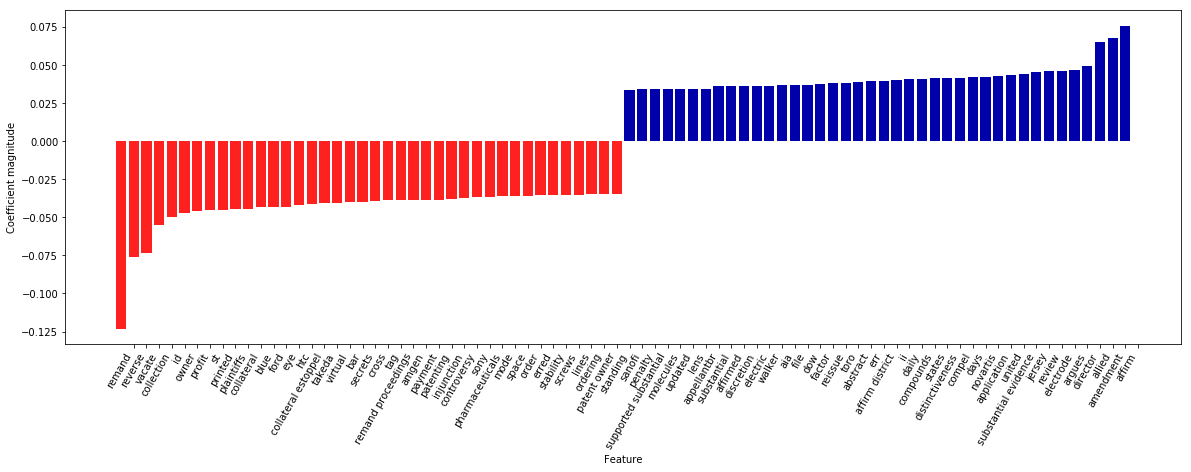

In [32]:
coefs = LogisticRegression(C=100).fit(X_train,y_train).coef_
feature_names = vect.get_feature_names()

visualize_coefficients(coefs, feature_names, 
                       n_top_features=40, fig_height=8, fig_width=20)


In [34]:
# find 2 and 3-gram features only

vect = TfidfVectorizer(ngram_range=(2,3),
                       min_df=10, 
                       norm=None,
                      stop_words="english").fit(text_train)

X = vect.transform(text_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(LogisticRegression(),param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))



Best cross-validation score: 0.70
Best parameters:
{'C': 0.01}


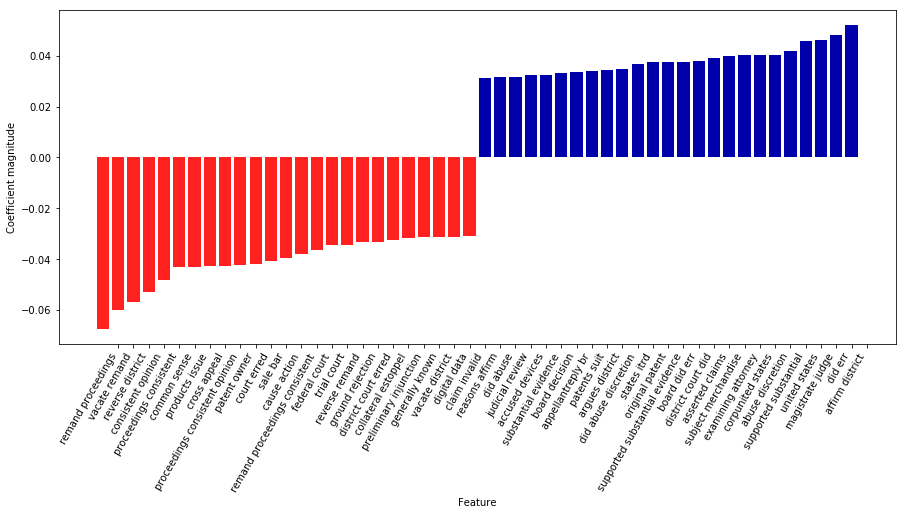

In [37]:
coefs = LogisticRegression(C=0.01).fit(X_train,y_train).coef_
feature_names = vect.get_feature_names()


visualize_coefficients(coefs, feature_names, n_top_features=25,
                      fig_height=8, fig_width=15)

## Advanced tokenization, stemming and lemmatization

In [38]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

# nltk.download('punkt') # may need to updated nltk by downloading modules
# nltk.download('wordnet') # may need to updated nltk by downloading modules

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    

In [39]:
# define a tf-idf vectorizer with the custom tokenizer
lemma_vect = TfidfVectorizer(ngram_range=(2,3),
                       min_df=10, 
                       norm=None,
                      stop_words="english",
               tokenizer=LemmaTokenizer())


In [40]:
from sklearn.model_selection import train_test_split

# transform text_train using CountVectorizer with lemmatization
X_lemma = lemma_vect.fit_transform(text_train)

X_train, X_test, y_train, y_test = train_test_split(X_lemma, y, random_state=42)

print("X_train.shape: {}".format(X_train.shape))


X_train.shape: (543, 10063)


In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=10)
# perform grid search with standard CountVectorizer
grid.fit(X_train, y_train)
print("Best cross-validation score "
      "(standard CountVectorizer): {:.3f}".format(grid.best_score_))


Best cross-validation score (standard CountVectorizer): 0.696


In [42]:
print("Best parameters:\n{}".format(grid.best_params_))

Best parameters:
{'C': 0.1}


In [47]:
feature_names = lemma_vect.get_feature_names()

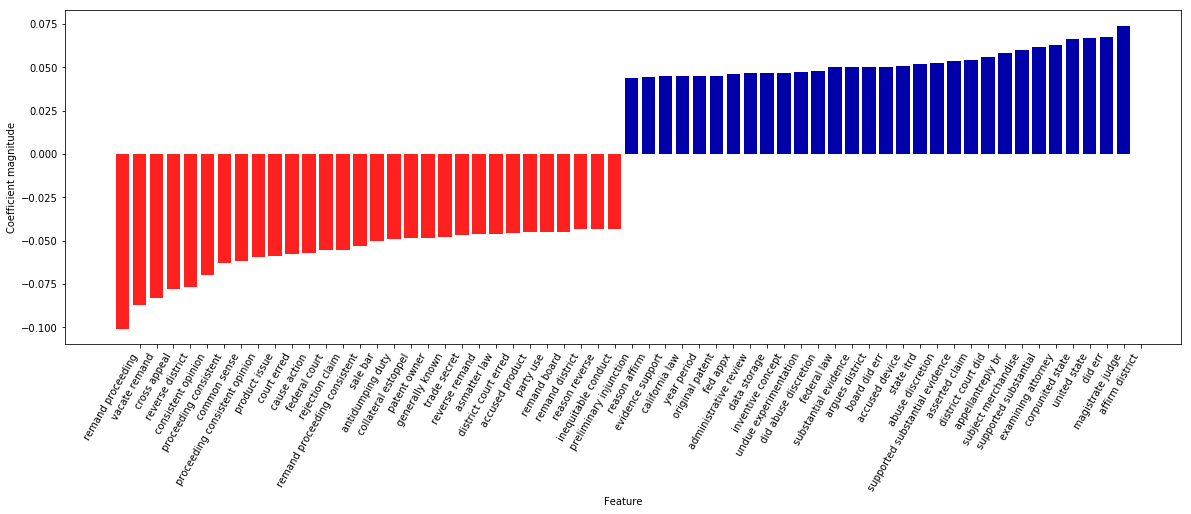

In [50]:
coefs = LogisticRegression(C=0.1).fit(X_train,y_train).coef_


visualize_coefficients(coefs, feature_names, n_top_features=30,
                      fig_height=8, fig_width=20)